In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from google.colab import drive
from sklearn.model_selection import train_test_split
import plotly.express as px

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
try:
  from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
  from statsmodels.tsa.ar_model import AutoReg
except:
  !pip install statsmodels --upgrade
  from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
  from statsmodels.tsa.ar_model import AutoReg

In [ ]:
'''
df2 = pd.read_csv('/content/gdrive/My Drive/Outdoor 1min_Wifi Thermometer_export_202204061200.csv')
df2=df2.rename(columns={'Timestamp\xa0for\xa0sample\xa0frequency\xa0every\xa01 min\xa0min': 
                        'Timestamp', 'Temperature_Fahrenheit': 'Temperature'})
df2=df2.set_index("Timestamp")
df2.index = pd.to_datetime(df2.index)
df2 = df2[['Temperature','Relative_Humidity']].resample("1H").mean()
df=df2.copy()
df=df[['Temperature','Relative_Humidity']].resample("1D").mean()
cutoff = int(len(df2)*0.80)
df_train = df2.iloc[:cutoff]
df_test = df2.iloc[cutoff:]
''';
train_ds = pd.read_csv('/content/gdrive/My Drive/atl_temp.csv')
df = pd.DataFrame({'ds':train_ds['datetime'], 'y': train_ds['temp']})
df['ds'] = pd.to_datetime(df['ds'])

In [ ]:
c = int(len(df)*0.80)
df_train = df.iloc[:c]
df_test = df.iloc[c:]

In [ ]:
df2 = df.copy()
df2.set_index(df2['ds'], inplace=True)
df2.drop(columns='ds', inplace=True)
df2

,y
ds,
2020-05-01,15.6
2020-05-02,18.7
2020-05-03,21.5
2020-05-04,23.4
2020-05-05,23.5
...,...
2022-04-27,16.4
2022-04-28,17.9
2022-04-29,18.9


In [ ]:
df2=df2.asfreq(freq='D')
df2=df2.squeeze()
print(f'The index is a {type(df2.index).__name__} type')

The index is a DatetimeIndex type


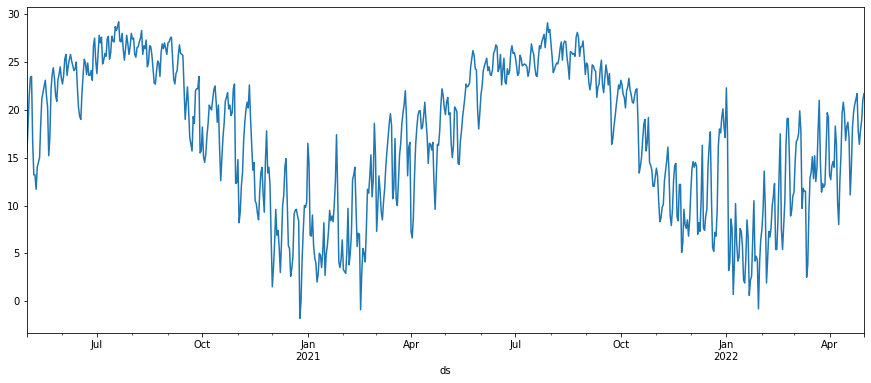

In [ ]:
'''AUTOREGRESSION'''
fig, ax = plt.subplots(figsize=(15, 6))
df2.plot(ax=ax);

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.




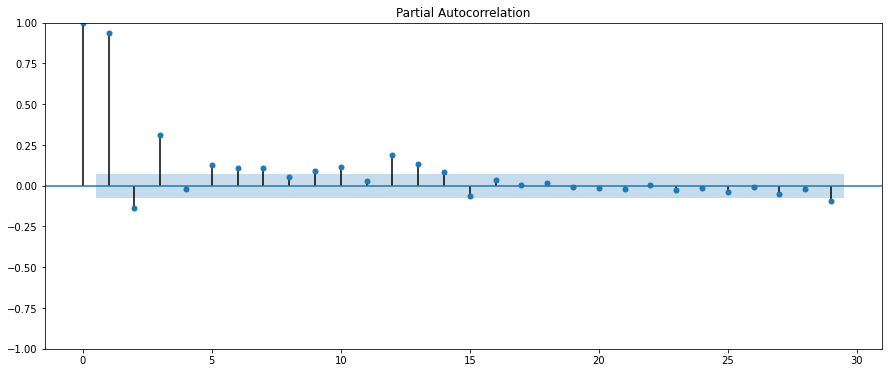

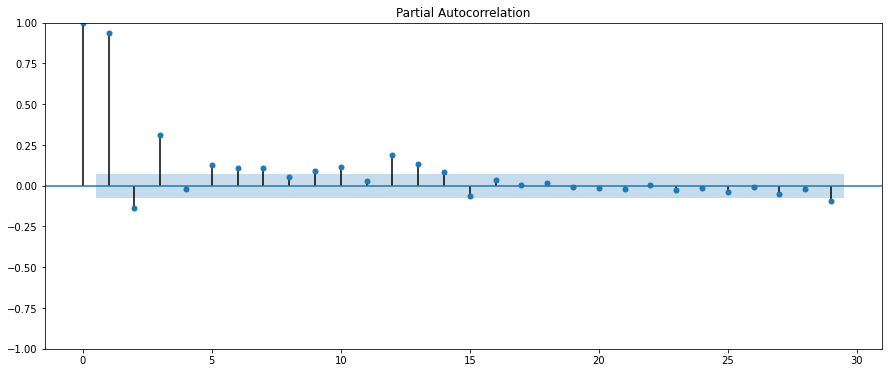

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df2, ax=ax)

In [ ]:
cutoff_test = int(len(df2)*0.80)
y_ar_train = df2.iloc[:cutoff_test]
y_ar_test = df2.iloc[cutoff_test:]
'''
p_params = range(1, 13)
maes = []
for p in p_params:
    model = AutoReg(y_train,lags=p).fit()
    maes.append(mean_absolute_error(y_train.iloc[p:], model.predict().dropna()))
mae_series = pd.Series(maes, name="mae", index=p_params)
best_lag = mae_series.idxmin()
best_model = AutoReg(y_train, lags=best_lag).fit()
''';
y_ar_train

ds
2020-05-01    15.6
2020-05-02    18.7
2020-05-03    21.5
2020-05-04    23.4
2020-05-05    23.5
              ... 
2021-12-01    11.5
2021-12-02    13.8
2021-12-03    14.6
2021-12-04    14.0
2021-12-05    14.5
Freq: D, Name: y, Length: 584, dtype: float64

In [ ]:
'''WALK FORWARD VALIDATION'''
def train(y_train, y_test, lags):
  y_pred_wfv = pd.Series()
  history = y_train.copy()
  for i in range(len(y_test)):
      model = AutoReg(history, lags=lags).fit()
      next_pred = model.forecast() #predict next time stamp
      y_pred_wfv= y_pred_wfv.append(next_pred) #append that prediction to the series
      history=history.append(y_test[next_pred.index]) #add the index of that prediction to the history
  return y_pred_wfv

In [ ]:
y_pred_wfv = train(y_ar_train, y_ar_test, 29)
y_pred_wfv

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.




2021-12-06    13.044343
2021-12-07    11.807611
2021-12-08     5.884933
2021-12-09     9.612025
2021-12-10     5.459607
                ...    
2022-04-27    16.647217
2022-04-28    17.703265
2022-04-29    17.192256
2022-04-30    19.405843
2022-05-01    20.773604
Freq: D, Length: 147, dtype: float64

In [ ]:
df_pred_test = pd.DataFrame(
{'y_test': y_ar_test, 'y_pred_wfv': y_pred_wfv})
fig = px.line(df_pred_test, labels={'value': 'Temperature'})
fig.show()

In [ ]:
try:
  from neuralprophet import NeuralProphet
except ModuleNotFoundError:
  !pip install git+https://github.com/ourownstory/neural_prophet.git
  from neuralprophet import NeuralProphet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-c7df82ip
  Running command git clone -q https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-c7df82ip
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 172 kB 14.9 MB/s 
  Created wheel for neuralprophet: filename=neuralprophet-0.3.3-py3-none-any.whl size=80630 sha256=fcc578fec2b98021b77157845757b08725b4f1fdde43b53c63bf04d6a279d1f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-9hq4j2vh/wheels/bc/d0/dd/f2b1133865669ed9b544f6f1ff9155aedf57c9dbfc72ce211e
Successfully built neuralprophet
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Success

In [ ]:
neural_model = NeuralProphet(n_lags=29)
neural_model.fit(df_train)
np_pred = neural_model.predict(df_train)
np_pred.dropna(inplace=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 237


  0%|          | 0/120 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.81E-03, min: 3.19E-01


  0%|          | 0/120 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.81E-03, min: 3.19E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.13E-02
Epoch[237/237]: 100%|██████████| 237/237 [00:31<00:00,  7.46it/s, SmoothL1Loss=0.00215, MAE=1.41, RMSE=1.85, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [ ]:
np_pred_test = neural_model.predict(df_test)
np_pred_test.dropna(inplace=True)
k = pd.DataFrame({'y': np_pred_test['y'], 'yhat': np_pred_test['yhat1']}).set_index(df_test.iloc[29: , :]['ds'])
k['yhat'] = k['yhat'].astype(float)
px.line(k, labels={'value': 'Temperature'})

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.32% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.324% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [ ]:
np_pred_test['yhat1']

29       1.14131
30      4.330587
31      5.415543
32      6.619567
33       1.01272
         ...    
142    10.414974
143     8.885502
144     9.980495
145    11.449514
146    14.010761
Name: yhat1, Length: 118, dtype: object

In [ ]:
df2 = pd.DataFrame({'AutoReg': y_pred_wfv, 'Actual': y_ar_test})
df2 = df2.iloc[29:, :]
df2=df2.reset_index().drop(columns='index')
df2['NP'] = np_pred_test['yhat1'].reset_index().drop(columns='index')
df2

,AutoReg,Actual,NP
0,3.724178,4.0,1.14131
1,7.007536,8.6,4.330587
2,8.148298,7.6,5.415543
3,9.586971,0.7,6.619567
4,3.984000,4.0,1.01272
...,...,...,...
113,16.647217,16.4,10.414974
114,17.703265,17.9,8.885502
115,17.192256,18.9,9.980495
116,19.405843,21.0,11.449514


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
y_train = df2['Actual']
X_train = df2.drop(columns='Actual')
rf_model.fit(df2.drop(columns='Actual'), y_train)
rf_pred = rf_model.predict(df2.drop(columns='Actual'))
rf_df = pd.DataFrame({'Temp': y_train, 'yhat': rf_pred}).set_index(df_test.iloc[29: , :]['ds'])
#px.line(rf_df, labels={'value': 'Temperature'})
rf_df['Temp'] = rf_df['Temp'].astype(float)
rf_df['yhat'] = rf_df['yhat'].astype(float)
px.line(rf_df, labels={'value': 'Temperature'})

In [ ]:
def checkAccuracy(y_val,y_pred):
    resid  = abs(y_pred - y_val)
    accuracy = 100 - np.mean((100 * (resid / y_val)))
    return accuracy

In [ ]:
gasData = pd.read_csv('/content/gdrive/My Drive/gas_price.csv')
gasData['DATE'] = pd.to_datetime(gasData['DATE'])
df3 = gasData.copy()
gasData.set_index(gasData['DATE'], inplace=True)
gasData = gasData.drop(columns='DATE')
gasData = gasData.iloc[1000:].astype(float)
gasData=gasData.asfreq(freq='W-MON')
gasData=gasData.squeeze()
gasData

DATE
2009-10-19    2.532
2009-10-26    2.641
2009-11-02    2.660
2009-11-09    2.627
2009-11-16    2.585
              ...  
2022-04-25    3.959
2022-05-02    4.031
2022-05-09    4.161
2022-05-16    4.320
2022-05-23    4.410
Freq: W-MON, Name: GASREGCOVW, Length: 658, dtype: float64

In [ ]:
test_split = int(len(gasData)*0.80)
gas_train = gasData.iloc[:test_split]
gas_test = gasData.iloc[test_split:]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.




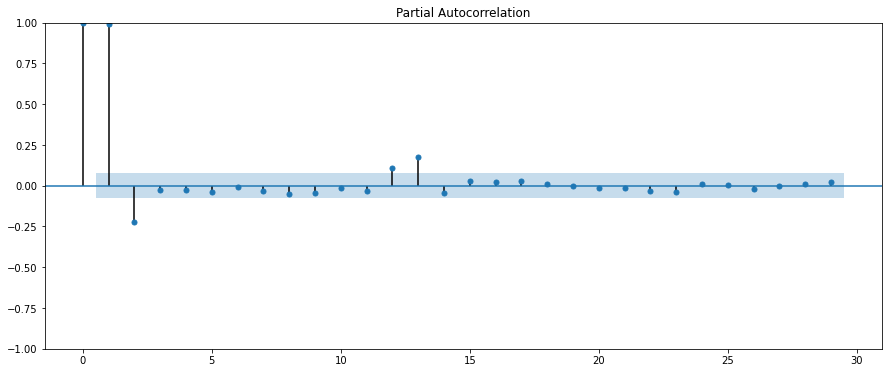

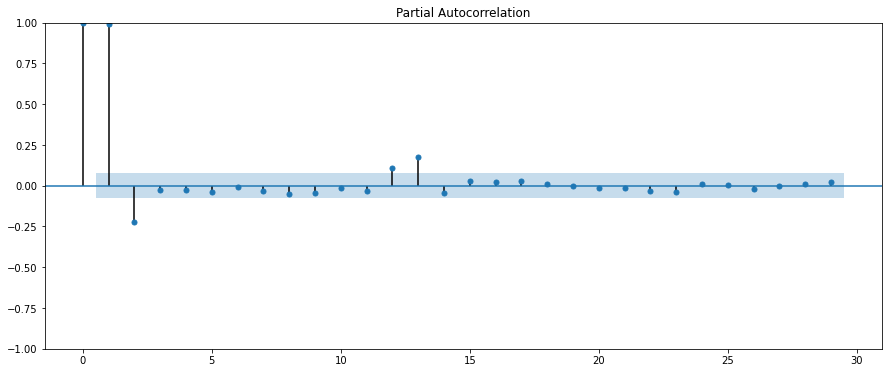

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(gasData, ax=ax)

In [ ]:
y_pred=train(gas_train, gas_test, 13)
pred_test = pd.DataFrame(
{'y_test': gas_test, 'y_pred': y_pred})
fig = px.line(pred_test, labels={'value': 'Gas Prices', 'index': 'Years'})
fig.show()

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.




In [ ]:
df3=df3.rename(columns={'DATE': 'ds', 'GASREGCOVW': 'y'})
df3=df3.iloc[1000:]
df3['y']=df3['y'].astype(float)
df3

,ds,y
1000,2009-10-19,2.532
1001,2009-10-26,2.641
1002,2009-11-02,2.660
1003,2009-11-09,2.627
1004,2009-11-16,2.585
...,...,...
1653,2022-04-25,3.959
1654,2022-05-02,4.031
1655,2022-05-09,4.161
1656,2022-05-16,4.320


In [ ]:
df3_split = int(len(df3)*0.80)
df3_train = df3.iloc[:df3_split]
df3_test = df3.iloc[df3_split:]

In [ ]:
np_model = NeuralProphet(n_lags=13)
np_model.fit(df3_train)
np_predictions = np_model.predict(df3_test)
np_predictions.dropna(inplace=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as W-MON
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 244


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.26E-01, min: 3.63E-01


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.51E-01, min: 7.32E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.24E-01
Epoch[244/244]: 100%|██████████| 244/244 [00:18<00:00, 13.41it/s, SmoothL1Loss=0.000207, MAE=0.0322, RMSE=0.0413, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.242% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.248% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


In [ ]:
np_frame = pd.DataFrame({'y': np_predictions['y'], 'yhat': np_predictions['yhat1']}).set_index(df3_test.iloc[13: , :]['ds'])
np_frame['yhat'] = np_frame['yhat'].astype(float)
px.line(np_frame, labels={'value': 'Gas Price', 'ds': 'Dates'})

In [ ]:
df4 = pd.DataFrame({'AR_model': y_pred, 'Actual': gas_test})
df4 = df4.iloc[13:, :]
df4=df4.reset_index().drop(columns='index')
df4['NP_model'] = np_predictions['yhat1'].reset_index().drop(columns='index')
df4

,AR_model,Actual,NP_model
0,2.308309,2.337,2.330234
1,2.347117,2.373,2.363685
2,2.387858,2.324,2.408998
3,2.295648,2.272,2.342287
4,2.250131,2.139,2.280867
...,...,...,...
114,3.894315,3.959,3.789469
115,3.986327,4.031,3.902395
116,4.051617,4.161,3.9291
117,4.173932,4.320,4.045245


In [ ]:
randomforest = RandomForestRegressor()
y_train_val = df4['Actual']
randomforest.fit(df4.drop(columns='Actual'), y_train_val)

RandomForestRegressor()

In [ ]:
rf_predictions = randomforest.predict(df4.drop(columns='Actual'))
rf = pd.DataFrame({'Gas Price': y_train_val, 'yhat': pd.Series(rf_predictions)})
rf = rf.set_index(df3_test.iloc[13: , :]['ds'])
rf['Gas Price'] = rf['Gas Price'].astype(float)
rf['yhat'] = rf['yhat'].astype(float)
px.line(rf, labels={'value': 'Gas Price', 'ds': 'Years'})